<a href="https://colab.research.google.com/github/seap-udea/fargopy/blob/main/fargopy_flux_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q git+https://github.com/juupitergeci/fargopy-dev.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import fargopy as fp
from fargopy.Fsimulation import DataHandler
%load_ext autoreload
%autoreload 2

Running FARGOpy version 0.3.12


# FARGOpy
## Wrapping FRAGO3D


## Interpolación en XYZ

La interpolación ahora se puede realizar en 3 dimensiones espaciales

In [ ]:

# Cargamos los datos de la simulación

fp.Simulation.download_precomputed('p3disoj')
sim=fp.Simulation(output_dir='/tmp/p3disoj')

# Cambiar dir_path por la ruta donde tienen los outputs de Fargo3D
#sim = fp.Simulation(output_dir='')

Precomputed output directory '/tmp/p3disoj' already exist
FARGO3D directory '/root/fargo3d/' does not exist.
Now you are connected with output directory '/tmp/p3disoj'
Found a variables.par file in '/tmp/p3disoj', loading properties
Loading variables
85 variables loaded
Simulation in 3 dimensions
Loading domain in spherical coordinates:
	Variable phi: 128 [[0, np.float64(-3.117048960983623)], [-1, np.float64(3.117048960983623)]]
	Variable r: 64 [[0, np.float64(0.5078125)], [-1, np.float64(1.4921875)]]
	Variable theta: 32 [[0, np.float64(1.4231400767948967)], [-1, np.float64(1.5684525767948965)]]
Number of snapshots in output directory: 11
Configuration variables and domains load into the object. See e.g. <sim>.vars


In [ ]:
# Creamos la instancia de la clase DataHandler
# y cargamos los datos de la simulación

data_handler = DataHandler(sim)
data_handler.load_data(

    # Definimos el snapshot inicial y el final sobre el que queremos trabajar
    snapi=1,
    snapf=10
);

Loading 3D data.


Ahora para interpolar en algun punto dentro del dominio:

In [ ]:
# Interpolamos el campo de densidad"

# Definimos las coordenadas y el tiempo en el que queremos interpolar
time=0.54
x=1.0
y=-0.25
z=0.05

# Interpolamos el campo de densidad
density = data_handler.interpolate_field(time,x,y,z,field_name="gasdens")
print(f"La densidad en las coordenadas {(x,y,z)} en el tiempo:{time}\n es : {density*sim.URHO*1e3:.3e}[kg/m^3]")

# Interpolar el campo de velocidad
velx,vely,velz = data_handler.interpolate_velocity(time,x,y,z)

La densidad en las coordenadas (1.0, -0.25, 0.05) en el tiempo:0.54
 es : 4.856e-07[kg/m^3]


# Cálculo del Flujo 3D


Primero,la clase flux.SphereTessellationnos permite crear la superficie de una esfera teselada de radio $r$ centrada en un punto arbitrario (x,y,z) dentro de nuestra simulación.La teselación se realiza con subdivisiones triangulares en un icosaedro.

Una vez se tiene la superficie teselada bien definida con sus centros y areas calculamos el flujo como:

$$ dJ = \rho\  \vec{v} \cdot d\vec{s} $$

Sumando sobre dJ tenemos el flujo total en un instante de tiempo

Ahora creamos el objeto analyzer desde FluxAnalyzer3D para calcular el flujo total en cada instante de tiempo de la simulación interpolada.


In [ ]:
from fargopy.flux import FluxAnalyzer3D
from fargopy import flux
import fargopy as fp
from fargopy.Fsimulation import DataHandler
%load_ext autoreload
%autoreload 2


# Cambiar dir_path por la ruta donde se tienen los outputs de Fargo3D
output_dir = '/tmp/p3disoj' # Cambiar por la ruta donde se tienen los outputs de Fargo3D
sim = fp.Simulation()


# Creamos el objeto
analyzer = FluxAnalyzer3D(
    output_dir=output_dir, # Cambiar por la ruta donde se tienen los outputs de Fargo3D
    sphere_center=(1, 0, 0), # Centro de la esfera (centrada en el planeta)
    radius=0.08,    # Radio de la esfera
    subdivisions=6,     # Número de subdivisiones
    snapi=1,        # Snapshot inicial
    snapf=10       # Snapshot final
)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
FARGO3D directory '/root/fargo3d/' does not exist.
FARGO3D directory '/root/fargo3d/' does not exist.
Now you are connected with output directory '/tmp/p3disoj'
Found a variables.par file in '/tmp/p3disoj', loading properties
Loading variables
85 variables loaded
Simulation in 3 dimensions
Loading domain in spherical coordinates:
	Variable phi: 128 [[0, np.float64(-3.117048960983623)], [-1, np.float64(3.117048960983623)]]
	Variable r: 64 [[0, np.float64(0.5078125)], [-1, np.float64(1.4921875)]]
	Variable theta: 32 [[0, np.float64(1.4231400767948967)], [-1, np.float64(1.5684525767948965)]]
Number of snapshots in output directory: 11
Configuration variables and domains load into the object. See e.g. <sim>.vars
Loading 3D data.


Podemos visualizar la región seleccionada para calcular el flujo con `analyzer.planet_sphere()`:

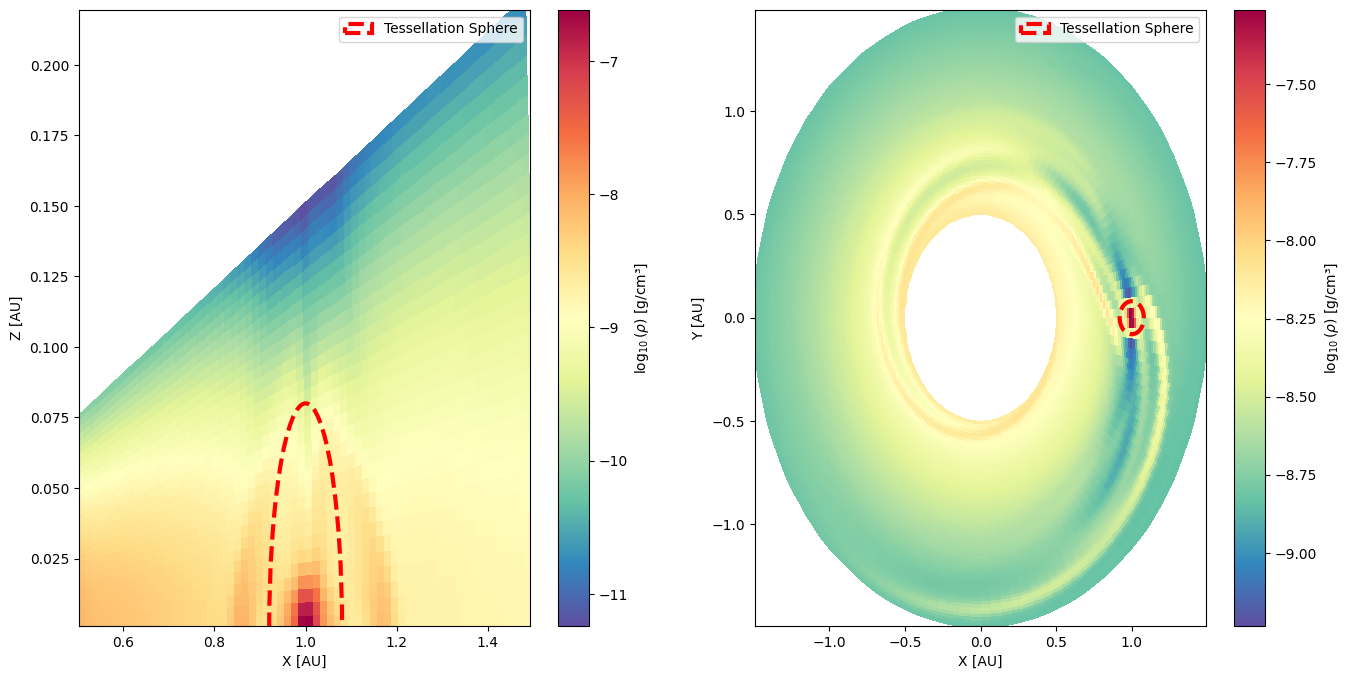

In [ ]:
analyzer.planet_sphere()

Interpolamos los campos de velocidad y densidad en los centros de las superficies con las que teselamos la esfera, esto se hace con el método `analyzer.interpolate(time_steps)`, definimos cuantas divisiones de tiempo queremos (resolución temporal)

In [ ]:

analyzer.interpolate(time_steps=100);


Interpolating fields: 100%|██████████| 100/100 [03:09<00:00,  1.89s/it]


Calculamos el flujo

In [ ]:
# Calcular flujos
analyzer.calculate_fluxes();

Graficamos los resultados:

In [ ]:
analyzer.plot_fluxes()



## Tasa de Acreción 3D

Para calcular la tasa de acreción utilizamos el método `analyzer.calculate_accretion()`, este nos devuelve la tasa de acreción en cada instante de tiempo y la masa total acretada durante la simulación:

Esta se calucula como:

$$ \dot{M} = \frac{d}{dt}\int_{V}{\rho\ dV} $$


Lo diferenciales de Volumen se definen a partir de la teselación, cada division de la superficie de la esfera es la base $ds$ de un tetraedro de altura $h=r$ con $r$ el radio de la esfera, este dV es entonces:  $dV=1/3 \cdot ds \cdot r$


Luego la masa total acretada se calcula como:


$$ M = \int \dot M \cdot dt$$

In [ ]:
import plotly.graph_objects as go
import numpy as np

# Calcular la tasa de acreción y la masa total
accretion_rate, total_mass = analyzer.calculate_accretion()

# Calcular el promedio de la tasa de acreción
avg_accretion_rate = np.mean(accretion_rate)


# Creamos el gráfico con plotly
fig = go.Figure()

# Agregar la línea de la tasa de acreción
fig.add_trace(go.Scatter(
    x=analyzer.time,
    y=accretion_rate,
    mode='lines',
    name='Accretion Rate',
    line=dict(color='dodgerblue', width=2)
))

# Agregar la línea promedio
fig.add_trace(go.Scatter(
    x=analyzer.time,
    y=[avg_accretion_rate] * len(analyzer.time),
    mode='lines',
    name=f'Avg: {avg_accretion_rate:.2e} Msun/yr',
    line=dict(color='orangered', width=2, dash='dash')
))

# Configurar el diseño del gráfico
fig.update_layout(
    title="Accretion Rate Over Time",
    xaxis_title="Normalized Time",
    yaxis_title="Accretion Rate [Msun/yr]",
    template="plotly_white",
    font=dict(size=14),
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True, exponentformat="e"),
)

# Mostrar el gráfico
fig.show()

In [ ]:
print(f"Total Accreted Mass: {total_mass:.2e} Msun")

Total Accreted Mass: -3.02e-05 Msun


# Cálculo del Flujo en 2D


En el caso que quisieramos calcular sobre los planos XY o YZ de la simulación (La simulación puede estár en esféricas, fargopy se encarga de pasarla a cartesianas) Se utiliza la clase `FluxAnalyzer2D`

En este caso se calcula el flujo a travez de un perímetro $l$, en este caso circular, se realiza dividiendo una circunferencia en sectores circulares de radio $r$ de n `subdivisión` centrado en la región que queremos calcular el flujo, este se calcula como:

$$ dJ = \rho\  \vec{v} \cdot d\vec{l} $$

Sumando sobre dJ tenemos el flujo total en un instante de tiempo

## Plano XY ----> $\theta=1.56$ [rad]

In [ ]:
import fargopy as fp
from fargopy.Fsimulation import DataHandler
from fargopy.flux import FluxAnalyzer2D
import numpy as np
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Creamos el objeto
analyzer = FluxAnalyzer2D(
    output_dir='/tmp/p3disoj', # Cambiar por la ruta donde se tienen los outputs de Fargo3D
    plane="XY",        # Definimos el plano en el que queremos trabajar
    angle="theta=1.56", # Definimos el ángulo en el que queremos trabajar
    snapi=1,    # Snapshot inicial
    snapf=10,   # Snapshot final
    center=(1.0,0.0), # Centro de la circunferencia(centrada en el planeta)
    radius=0.1,  # Radio de la circunferencia
    subdivisions=100 # Número de subdivisiones
)

FARGO3D directory '/root/fargo3d/' does not exist.
Now you are connected with output directory '/tmp/p3disoj'
Found a variables.par file in '/tmp/p3disoj', loading properties
Loading variables
85 variables loaded
Simulation in 3 dimensions
Loading domain in spherical coordinates:
	Variable phi: 128 [[0, np.float64(-3.117048960983623)], [-1, np.float64(3.117048960983623)]]
	Variable r: 64 [[0, np.float64(0.5078125)], [-1, np.float64(1.4921875)]]
	Variable theta: 32 [[0, np.float64(1.4231400767948967)], [-1, np.float64(1.5684525767948965)]]
Number of snapshots in output directory: 11
Configuration variables and domains load into the object. See e.g. <sim>.vars
Loading 2D data for plane XY at angle theta=1.56 rad.


Visualizamos la Región sobre la que calcularemos el flujo

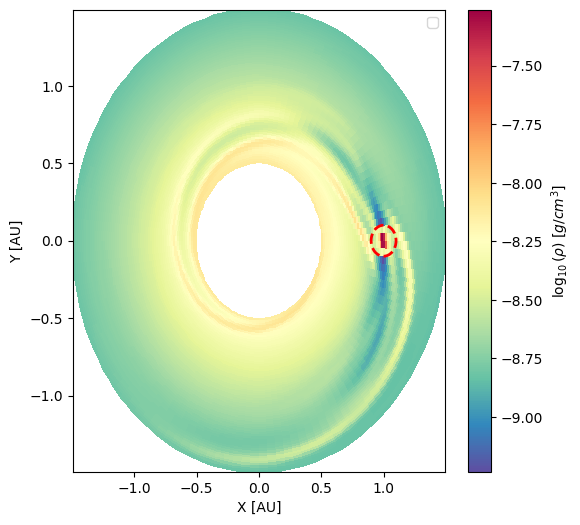

In [ ]:
# Visualizar la región con la densidad de fondo
analyzer.plot_region()

Hallamos el valor del campo de densidad y velocidad en el centro de cada lado del polígono:


- `analyzer.interpolate(time_steps=100)[0]` devuelve los valores del campo de velocidad
- `analyzer.interpolate(time_steps=100)[1]` devuelve los valores del campo de densidad


In [ ]:
analyzer.interpolate(time_steps=100);



Interpolating fields: 100%|██████████| 100/100 [02:52<00:00,  1.72s/it]


Calculamos el flujo:


In [ ]:
analyzer.calculate_fluxes();

Visualizamos el flujo a travéz del tiempo

In [ ]:
analyzer.plot_fluxes()

## Tasa de Acreción 2D

Para calcular la tasa de acreción utilizamos el método `analyzer.calculate_accretion()`, este nos devuelve la tasa de acreción en cada instante de tiempo y la masa total acretada durante la simulación:

Esta se calucula como:

$$ \dot{M} = \frac{d}{dt}\int_{s}{\rho\ ds} $$

En este caso el $ds$ corresponde al area de cada sector circular en el que se dividió la circunferencia.


Luego la masa total acretada se calcula como:


$$ M = \int \dot M \cdot dt$$


In [ ]:
# Calculate accretion rate and total accreted mass
accretion_rate, total_mass = analyzer.calculate_accretion()


In [ ]:
import plotly.graph_objects as go
import numpy as np

# Calcular el promedio de la tasa de acreción
avg_accretion_rate = np.mean(accretion_rate)



# Crear la figura con Plotly
fig = go.Figure()

# Agregar la línea de la tasa de acreción
fig.add_trace(go.Scatter(
    x=analyzer.time,
    y=accretion_rate,
    mode='lines',
    name='Accretion Rate',
    line=dict(color='dodgerblue', width=2)
))

# Agregar la línea promedio
fig.add_trace(go.Scatter(
    x=analyzer.time,
    y=[avg_accretion_rate] * len(analyzer.time),
    mode='lines',
    name=f'Avg: {avg_accretion_rate:.2e} Msun/yr',
    line=dict(color='orangered', width=2, dash='dash')
))


fig.update_layout(
    title="Accretion Rate Over Time",
    xaxis_title="Normalized Time",
    yaxis_title="Accretion Rate [Msun/yr]",
    template="plotly_white",
    font=dict(size=14),
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True, exponentformat="e"),
)


fig.show()

In [ ]:
print(f"Total Accreted Mass: {total_mass:.2e} Msun")

Total Accreted Mass: -7.38e-05 Msun


## Plano XZ----> $\phi=0$

In [ ]:
# Crear una instancia de FluxAnalyzer2D
analyzer = FluxAnalyzer2D(
    output_dir='/tmp/p3disoj', # Cambiar por la ruta donde se tienen los outputs de Fargo3D
    plane="XZ", # Definimos el plano en el que queremos trabajar
    angle="phi=0", # Definimos el ángulo en el que queremos trabajar
    snapi=1, # Snapshot inicial
    snapf=10, # Snapshot final
    center=(1.0,0.0), # Centro de la circunferencia(centrada en el planeta)
    radius=0.1, # Radio de la circunferencia
    subdivisions=100 # Número de subdivisiones
)

FARGO3D directory '/root/fargo3d/' does not exist.
Now you are connected with output directory '/tmp/p3disoj'
Found a variables.par file in '/tmp/p3disoj', loading properties
Loading variables
85 variables loaded
Simulation in 3 dimensions
Loading domain in spherical coordinates:
	Variable phi: 128 [[0, np.float64(-3.117048960983623)], [-1, np.float64(3.117048960983623)]]
	Variable r: 64 [[0, np.float64(0.5078125)], [-1, np.float64(1.4921875)]]
	Variable theta: 32 [[0, np.float64(1.4231400767948967)], [-1, np.float64(1.5684525767948965)]]
Number of snapshots in output directory: 11
Configuration variables and domains load into the object. See e.g. <sim>.vars
Loading 2D data for plane XZ at angle phi=0 rad.


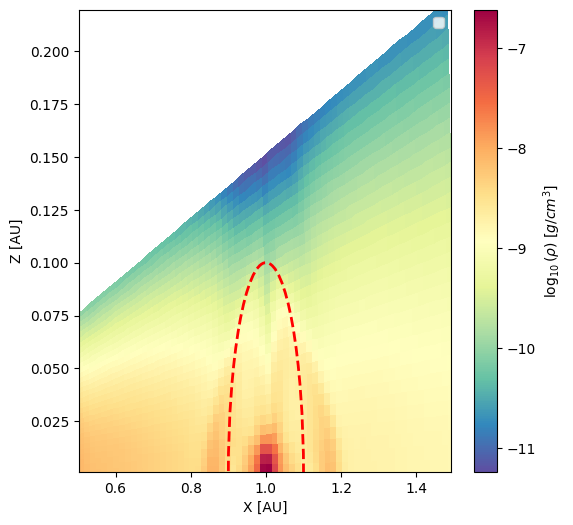

In [ ]:
# Visualizar la región con la densidad de fondo y la circunferencia
analyzer.plot_region()

In [ ]:

# Interpolar los campos
analyzer.interpolate(time_steps=100);

Interpolating fields: 100%|██████████| 100/100 [00:31<00:00,  3.13it/s]


In [ ]:
# Calculamos el flujo de masa y graficamos
analyzer.calculate_fluxes();
analyzer.plot_fluxes()

Ahora calculamos la tasa de acreción y la masa todal acretada


In [ ]:
import plotly.graph_objects as go
import numpy as np

# Calculate accretion rate and total accreted mass
accretion_rate, total_mass = analyzer.calculate_accretion()
# Calcular el promedio de la tasa de acreción
avg_accretion_rate = np.mean(accretion_rate)



# Crear la figura con Plotly
fig = go.Figure()

# Agregar la línea de la tasa de acreción
fig.add_trace(go.Scatter(
    x=analyzer.time,
    y=accretion_rate,
    mode='lines',
    name='Accretion Rate',
    line=dict(color='dodgerblue', width=2)
))

# Agregar la línea promedio
fig.add_trace(go.Scatter(
    x=analyzer.time,
    y=[avg_accretion_rate] * len(analyzer.time),
    mode='lines',
    name=f'Avg: {avg_accretion_rate:.2e} Msun/yr',
    line=dict(color='orangered', width=2, dash='dash')
))


fig.update_layout(
    title="Accretion Rate Over Time",
    xaxis_title="Normalized Time",
    yaxis_title="Accretion Rate [Msun/yr]",
    template="plotly_white",
    font=dict(size=14),
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True, exponentformat="e"),
)


fig.show()

In [ ]:
print(f"Total Accreted Mass: {total_mass:.2e} Msun")

Total Accreted Mass: -1.73e-05 Msun
